In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use("paper")

import cosmology
from hbtp import HBTReader
from src.prof import HBTProfileReader
from src.cmh import HBTHistoryReader
from src import read

In [2]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
NFW_f = 0.02
nbins = 20
bin = 10
r = HBTReader("./data/%s/subcat" % grav)
prof_reader = HBTProfileReader("./data/%s/subcat" % grav)
hist_reader = HBTHistoryReader("./data/%s/subcat" % grav)

In [3]:
def bin_haloes(haloes, bin_column, bin_edges, transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(haloes, 'bin',\
        np.digitize(transform(haloes[bin_column]), bin_edges),\
        usemask=False)
    return hs

def read_haloes(r, snap):
    hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
    # hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
    hs = hs[hs['M200Crit'] >= 20]
    hs['M200Crit'] = 1e10*hs['M200Crit']
    return hs

hs = read_haloes(r, snap)
_, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
hs = hs[hs['bin'] == bin]

Haloes number 2, 5 and 12 are the ones with the most pronounced increase-then-decrease mass histories

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


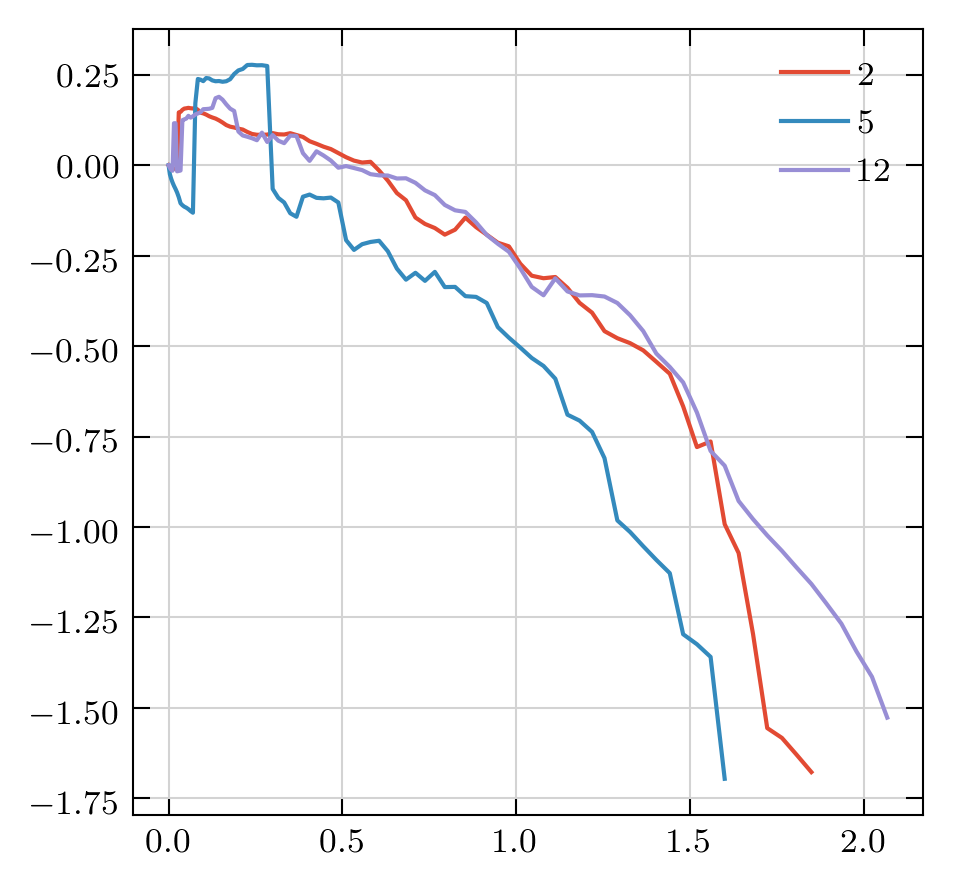

In [4]:
ys = np.array(
    pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))\
        .set_index('HostHaloId')\
        .fillna(0.0)\
        .loc[hs['HaloId']]\
        .dropna(),
    dtype=float
)
ys = np.divide(ys.T, ys[:,-1]).T

zs = read.snaps()
x = cosmology.rho_c(
    np.array([
        zs[zs['Snapshot'] == s][0]['Redshift']
        for s in np.arange(1+snap-ys.shape[1], 1+snap)
    ])) / \
    cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

fig, ax = plt.subplots(1)    

for i in [2, 5, 12]:
    ax.plot(np.log10(x), np.log10(ys[i,:]), label=i)

ax.legend()

In [5]:
mh = hist_reader.GetProgenitorHaloesRecursive(8, 23)

In [6]:
mh

[(18, 227),
 (20, 985),
 (22, 12),
 (20, 546),
 (20, 52),
 (17, 244),
 (19, 37),
 (21, 9),
 (20, 330),
 (19, 825),
 (20, 777),
 (22, 516),
 (21, 784),
 (19, 598),
 (18, 136)]

In [7]:
def findclosestsquare(num):
    num_sqrt = np.sqrt(num)
    if int(num_sqrt) == num_sqrt:
        return num
    else:
        return int(num_sqrt + 1) * int(num_sqrt + 1)

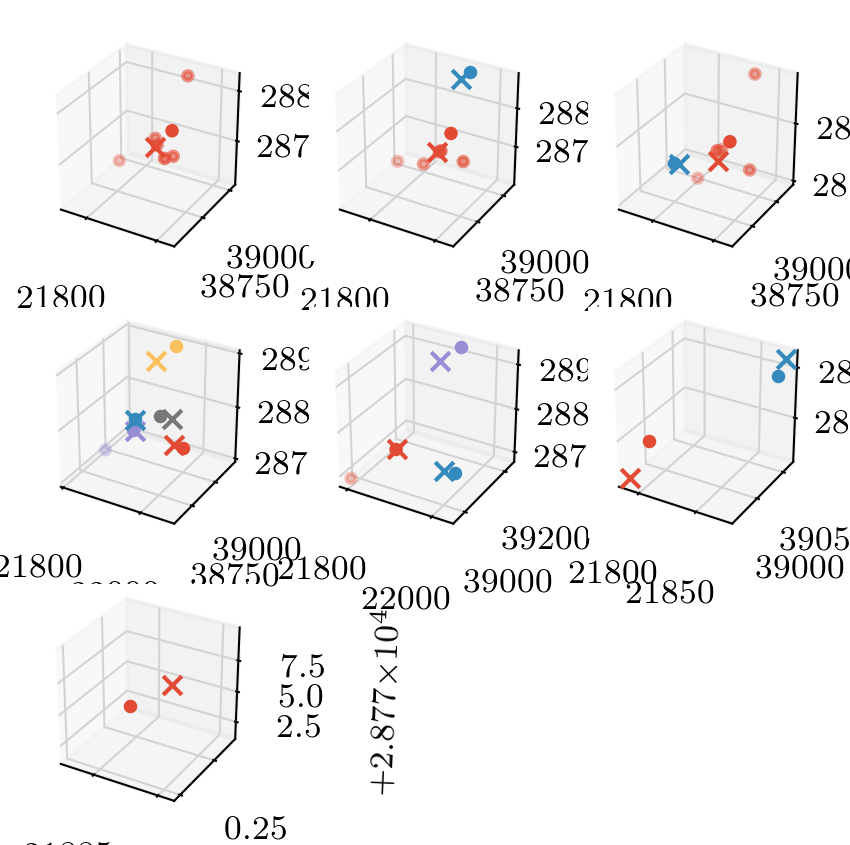

In [8]:
mh = [
    (23, [8,]),
    (22, [12, 516]),
    (21, [9, 784]),
    (20, [985, 546, 52, 330, 777]),
    (19, [37, 825, 598]),
    (18, [227, 136]),
    (17, [244]),
]
gridsize = int(np.sqrt(findclosestsquare(len(mh))))
fig = plt.figure()

for i, s in enumerate(mh):
    
    ax = fig.add_subplot(
        gridsize, gridsize, i+1,
        projection='3d')

    for j, h in enumerate(s[1]):
        positions = prof_reader.GetSubsOfHost(h, s[0])['ComovingAveragePosition']
        ax.scatter(*prof_reader.GetHostHalo(h, s[0])['CenterComoving'], color='C%d'%j, marker='x')
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='C%d'%j, marker='.')